Мы начинаем лабораторную! Я буду с Вами в течение часа. Вы можете задавать мне вопросы по заданию, которые Вам не понятны или не очевидны. Я буду на них отвечать  Затем у вас будет 2 часа самостоятельно доделать работу.
Решения никуда выкладывать не нужно, по истечении времени правильное решение будет опубликовано в канале Слака, и можно будет сравнить свои ответы с правильным. При наличии вопросов - их можно будет задать и обсудить.
Дан набор данных по оттоку клиентов. Набор данных содержит всего 5 000 записей (т.е. абонентов). Данные доступны тут - https://drive.google.com/open?id=1ArslqEEno2hrr5tAs25P0JN0P-coLcFD
Перечень полей:

state – штат;

account length – абонентский стаж;

area code – код региона;

phone number – номер телефона;

international plan – тарифный план для международных звонков;

voice mail plan – тарифный план для голосовой почты;

number vmail messages – количество сообщений голосовой почты;

total day minutes – общая длительность звонков в дневное время (мин);

total day calls – общее количество звонков в дневное время;

total day charge – общая стоимость звонков в дневное время;

total eve minutes – общая длительность звонков в вечернее время (мин);

total eve calls – общее количество звонков в вечернее время;

total eve charge – общая стоимость звонков в вечернее время;

total night minutes – общая длительность звонков в ночное время (мин);

total night calls – общее количество звонков в ночное время;

total night charge – общая стоимость звонков в ночное время;

total intl minutes – общая длительность международных звонков (мин);

total intl calls – общее количество международных звонков;

total intl charge – общая стоимость международных звонков;

number customer service calls – количество звонков в службу поддержки.

churned – покинул ли клиент компанию

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [177]:
df = pd.read_csv('churn.csv')
df.head(2)

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


### Построить гистограмму количества звонков в техническую поддержку

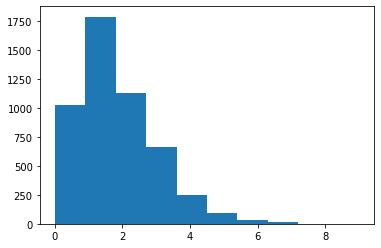

In [178]:
fig =  plt.Figure()
plt.hist(df['number_customer_service_calls'])

plt.show()

### Рассчитать и построить гистограмму общей длительности звонков клиента (дневных + ночных + вечерних + международных)

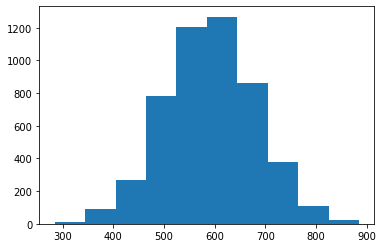

In [179]:
fig =  plt.Figure()
total_minutes = df['total_day_minutes']+df['total_eve_minutes']+df['total_night_minutes']+df['total_intl_minutes']
plt.hist(total_minutes)

plt.show()

### Собственноручно (не используя встроенных функций) рассчитать линейный коэффициент корреляции (https://ru.wikipedia.org/wiki/Корреляция) общего количества минут и количества звонков в техподдержку
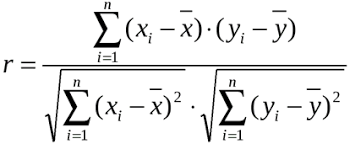

In [180]:
dx = total_minutes - total_minutes.mean()
dy = df['number_customer_service_calls'] - df['number_customer_service_calls'].mean()

sum(dx*dy)/np.sqrt(sum(dx**2)*sum(dy**2))

-0.01140791082744116

In [181]:
total_minutes.corr(df['number_customer_service_calls'])

-0.011407910827441392

### Визуализировать точечный график по общему количеству минут / количеству звонков в поддержку, подкрасив точки в зависимости от оттока абонента

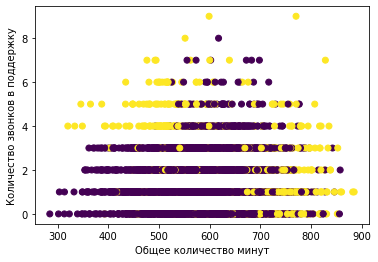

In [182]:
fig =  plt.Figure()
plt.scatter(total_minutes, df['number_customer_service_calls'], c=df['churned'])


plt.xlabel('Общее количество минут')
plt.ylabel('Количество звонков в поддержку')
plt.show()

### Вывести top-5 самых много и самых мало говорящих клиентов

In [183]:
total_minutes.sort_values().head()

648     284.3
1233    301.5
3779    303.2
1986    313.0
992     313.3
dtype: float64

In [184]:
total_minutes.sort_values(ascending=False).head()

985     885.0
289     882.2
3205    860.2
4991    858.2
4271    857.4
dtype: float64

### Вывести долю оттока клиентов и среднюю стоимость минуты дневного времени разговора  в зависимости от штата

In [185]:
df['total_day_charge_for_minutes'] = df['total_day_charge']/ df['total_day_minutes']
df.groupby('state')[['churned', 'total_day_charge_for_minutes']].agg('mean').sort_values('churned', ascending=False).head()

,churned,total_day_charge_for_minutes
state,,
CA,0.269231,0.170003
NJ,0.250000,0.170001
WA,0.244898,0.170002
TX,0.224138,0.170003
MT,0.212121,0.170001


### Перевести штат в one-hot формат при помощи pandas-функции get_dummies или удалите колонку, если вы делаете решение на pyspark

In [186]:
df_ml = df.merge(pd.get_dummies(df['state']), left_index=True, right_index=True)
df_ml.drop('state',axis=1, inplace=True)

### Разбить данные на множество для обучения и для проверки, отобрав признаки для обучения модели классификации (убрать номер телефона, код региона, признаки планов + все добавленные аттрибуты)

In [187]:
X = df_ml.drop(labels=['phone_number', 'area_code', 'international_plan', 'voice_mail_plan', 'total_day_charge_for_minutes','churned'], axis=1)
y = df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Обучить какую-нибудь модель классификации и оценить качество (точность) на отложенной выборке

In [188]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [189]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)


RandomForestClassifier()

In [190]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, clf.predict(X_test))

0.931

In [191]:
from sklearn.metrics import f1_score

f1_score(y_test, clf.predict(X_test), average='micro')

0.931